In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import sys
sys.path.append("/Users/ccamargo/Documents/github/SLB/")

from utils_SLB import cluster_mean # , sum_linear, sum_square, get_dectime

import scipy.stats as st
# from scipy import stats
import sklearn.metrics as metrics

import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore","Mean of empty slice", RuntimeWarning)
warnings.filterwarnings("ignore","divide by zero encountered in double_scalars", RuntimeWarning)
        

In [4]:
def create_noise(mu,sigma,t):
    noise = np.random.normal(mu,sigma,t)
    return noise
def create_ts(x,t):
    return np.array(np.linspace(0,(x/t)*2,t))
def perturb_rate(rate,unc,t):
    return create_ts(rate,t) + create_noise(0,1,t)*create_ts(unc,t)

In [5]:

# dimensions
period = ['1993-2017'] # full years
y0,y1=period[0].split('-')
t0='{}-01-01'.format(int(y0))
t1='{}-12-31'.format(int(y1)-1)
path = '/Volumes/LaCie_NIOZ/data/budget/ts/' 
ds = xr.open_dataset(path+'alt.nc')
ds = ds.sel(time=slice(t0,t1))
lat=np.array(ds.lat)
lon=np.array(ds.lon)

In [6]:
#%% get budget components
path = '/Volumes/LaCie_NIOZ/data/budget/'
dic = pd.read_pickle(path+'budget_v2.pkl')

## Test for 1 cluster

In [7]:
key = 'som'
mask = np.array(dic[key]['mask'])

icluster = 1
maskc = np.array(mask)
maskc[mask!=icluster] = np.nan
maskc[np.isfinite(maskc)] = 1
        

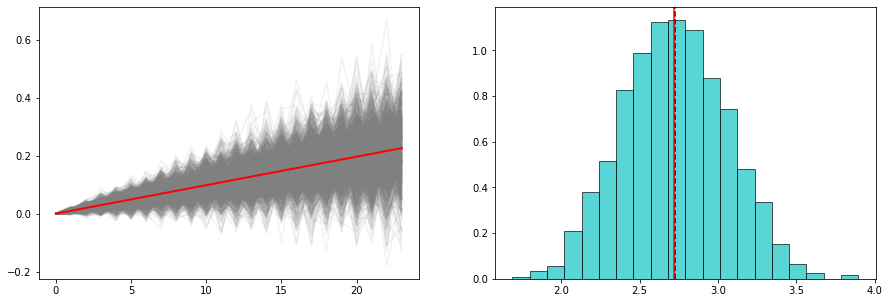

In [8]:
var = 'sum'

X = np.array(dic[var]['trend'])
x = cluster_mean(np.array(X),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
Xe = np.array(dic[var]['unc'])
xe = cluster_mean(np.array(Xe),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)

Y = np.array(dic['alt']['trend'])
y = cluster_mean(np.array(Y),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
Ye = np.array(dic['alt']['unc'])
ye = cluster_mean(np.array(Ye),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)



t = 2017-1993 # number of years
N = 1000 # number of ensembles
samples = np.zeros((N,t))
slopes = np.zeros((N))
np.random.seed(1) # Fix random number generator
plt.figure(figsize=(15,5))
plt.subplot(121)

for i in range(N):
    #xt = np.array(np.linspace(0,(x/t)*2,t)+create_noise(0,1,t)*np.linspace(0,(xe/t)*2,t))
    samples[i] = np.array(perturb_rate(y,ye,t))
    plt.plot(samples[i],alpha=0.1,color='gray')
    slopes[i] = np.cumsum(samples[i])[-1]
    
plt.plot(np.linspace(0,(y/t)*2,t),linewidth=2,color='r')   
plt.subplot(122)
plt.hist(slopes, bins=20, color='c', edgecolor='k',
                          density=True,
                          alpha=0.65)
plt.axvline(slopes.mean(),color='k',linestyle='--')
plt.axvline(y,color='r',linestyle='-')
plt.show()


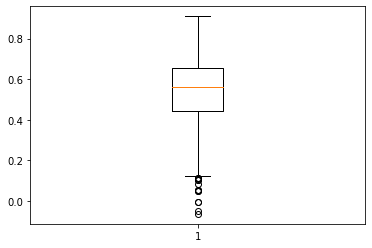

(0.22084286761423522, 0.8601498765442469)
(-0.7123418775187561, 0.8287900586577103)


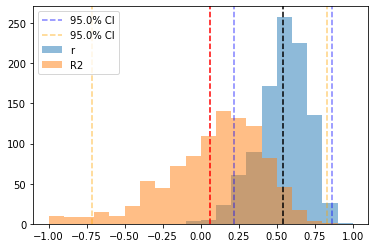

In [9]:
t = 2017-1993 # number of years
N = 1000 # number of ensembles
xs = np.zeros((N))
ys = np.zeros((N))
rs= np.zeros((N))
R2s = np.zeros((N))
np.random.seed(1) # Fix random number generator


for i in range(N):
    #xt = np.array(np.linspace(0,(x/t)*2,t)+create_noise(0,1,t)*np.linspace(0,(xe/t)*2,t))
    xt = np.array(perturb_rate(x,xe,t))
    yt = np.array(perturb_rate(y,ye,t))
    xs[i] = np.cumsum(xt)[-1]
    ys[i] = np.cumsum(yt)[-1]
    rs[i],_ = st.pearsonr(xt,yt)
    R2s[i] = metrics.r2_score(yt,xt)

plt.figure()
plt.boxplot(rs)
plt.show()


ci_level=0.95
plt.hist(rs,label='r',alpha=0.5,
         bins=np.arange(-1, 1+0.1,0.1))

ci = st.norm.interval(alpha=ci_level, loc=np.mean(rs), scale=rs.std())
plt.axvline(rs.mean(),color='k',linestyle='--')

plt.axvline(ci[0],c='blue',linestyle='--',alpha=0.5,label='{}% CI'.format(ci_level*100))
plt.axvline(ci[1],c='blue',linestyle='--',alpha=0.5)
print(ci)
plt.hist(R2s, bins=np.arange(-1, 1+0.1,0.1),
         alpha=0.5,
        label='R2')
ci = st.norm.interval(alpha=ci_level, loc=np.mean(R2s), scale=R2s.std())
plt.axvline(R2s.mean(),color='r',linestyle='--')

plt.axvline(ci[0],c='orange',linestyle='--',alpha=0.5,label='{}% CI'.format(ci_level*100))
plt.axvline(ci[1],c='orange',linestyle='--',alpha=0.5)
print(ci)
plt.legend()
plt.show()


## For all clusters

In [10]:
i = 2
varis = ['sum']
t = 2017-1993 # number of years
N = 1000 # number of ensembles
r=[]
R2 = []
for key in ['som']:
    
    mask = dic[key]['mask']
    n = dic[key]['n']
    nvar = len(varis)

    for i in range(n):
        icluster = i+1

        maskc = np.array(mask)
        maskc[mask!=icluster] = np.nan
        maskc[np.isfinite(maskc)] = 1

        label = 'alt'
        y =  cluster_mean(np.array(dic[label]['trend']),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
        ye =  cluster_mean(np.array(dic[label]['unc']),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)


        for j,var in enumerate(varis):
            if len(var.split('+'))==1:
                X = np.array(dic[var]['trend'])
                Xe = np.array(dic[var]['trend'])

            else:
                X = np.array([dic[subvar]['trend'] for subvar in var.split('+')])
                X = np.sum(np.array(X),axis=0)
                Xe = np.array([dic[subvar]['trend'] for subvar in var.split('+')])
                Xe = np.sqrt(np.sum(np.array(Xe**2),axis=0))
                
            x = cluster_mean(np.array(X),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
            xe = cluster_mean(np.array(Xe),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)

            for i in range(N):
                #xt = np.array(np.linspace(0,(x/t)*2,t)+create_noise(0,1,t)*np.linspace(0,(xe/t)*2,t))
                xt = np.array(perturb_rate(x,xe,t))
                yt = np.array(perturb_rate(y,ye,t))
                xs[i] = np.cumsum(xt)[-1]
                ys[i] = np.cumsum(yt)[-1]
                _r,p = st.pearsonr(xt,yt)
                r.append(_r)
                R2.append(metrics.r2_score(yt,xt))

           


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc17d537110>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc17d79b510>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc17d537090>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc17d79bfd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc17d7a2550>],
 'means': []}

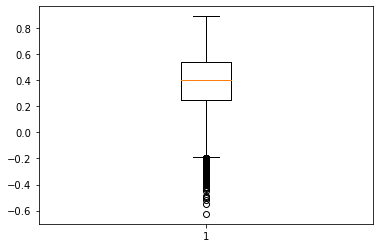

In [11]:
plt.boxplot(r)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc17d8a25d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc17d8a9090>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc17d8a20d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc17d8a9b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc17d8b20d0>],
 'means': []}

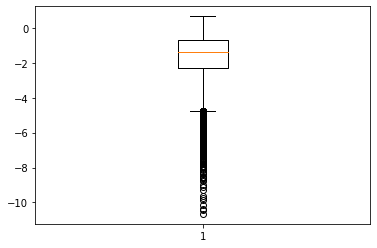

In [12]:
plt.boxplot(R2)

(-0.03987707426795134, 0.7999463627237156)
(-4.235910947026246, 0.9354594020237228)


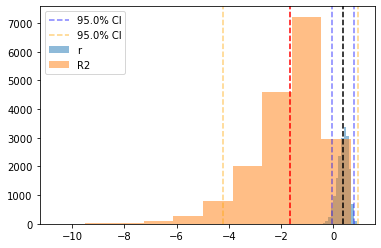

In [13]:
ci_level=0.95
plt.hist(r,label='r',alpha=0.5,
         bins=np.arange(-1, 1+0.1,0.1))

ci = st.norm.interval(alpha=ci_level, loc=np.mean(r), scale=np.array(r).std())
plt.axvline(np.array(r).mean(),color='k',linestyle='--')

plt.axvline(ci[0],c='blue',linestyle='--',alpha=0.5,label='{}% CI'.format(ci_level*100))
plt.axvline(ci[1],c='blue',linestyle='--',alpha=0.5)
print(ci)
plt.hist(R2, 
         # bins=np.arange(-1, 1+0.1,0.1),
         alpha=0.5,
        label='R2')
ci = st.norm.interval(alpha=ci_level, loc=np.mean(R2), scale=np.array(R2).std())
plt.axvline(np.array(R2).mean(),color='r',linestyle='--')

plt.axvline(ci[0],c='orange',linestyle='--',alpha=0.5,label='{}% CI'.format(ci_level*100))
plt.axvline(ci[1],c='orange',linestyle='--',alpha=0.5)
print(ci)
plt.legend()
plt.show()


## saving only CI for the ensemble

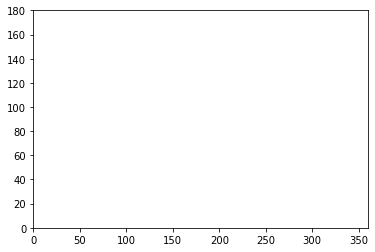

In [29]:
plt.pcolor(maskc*Xe)

In [30]:
x

array(nan)

In [31]:
stats={}
varis = ['sum',
            'steric',
             'barystatic',
             'dynamic',
         'steric+dynamic',
         'steric+barystatic',
         'steric+barystatic+dynamic'
                   ]       
t = 2017-1993 # number of years
N = 1000 # number of ensembles
r=[]
R2 = []
for key in ['dmap','som']:
    
    mask = dic[key]['mask']
    n = dic[key]['n']
    if key =='dmap':
        mask[mask==1]=np.nan
        mask = mask-1
        n = len(np.unique(mask[np.isfinite(mask)]))

    nvar = len(varis)

    for i in range(n):
        icluster = i+1

        maskc = np.array(mask)
        maskc[mask!=icluster] = np.nan
        maskc[np.isfinite(maskc)] = 1

        label = 'alt'
        y =  cluster_mean(np.array(dic[label]['trend']),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
        ye =  cluster_mean(np.array(dic[label]['unc']),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
        if np.isfinite(y):

            for j,var in enumerate(varis):
                if len(var.split('+'))==1:
                    X = np.array(dic[var]['trend'])
                    Xe = np.array(dic[var]['trend'])

                else:
                    X = np.array([dic[subvar]['trend'] for subvar in var.split('+')])
                    X = np.sum(np.array(X),axis=0)
                    Xe = np.array([dic[subvar]['trend'] for subvar in var.split('+')])
                    Xe = np.sqrt(np.sum(np.array(Xe**2),axis=0))
                if np.isfinite(x):
                    x = cluster_mean(np.array(X),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
                    xe = cluster_mean(np.array(Xe),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
                    rr=[]
                    RR = []
                    for i in range(N):
                        #xt = np.array(np.linspace(0,(x/t)*2,t)+create_noise(0,1,t)*np.linspace(0,(xe/t)*2,t))
                        xt = np.array(perturb_rate(x,xe,t))
                        yt = np.array(perturb_rate(y,ye,t))
                        xs[i] = np.cumsum(xt)[-1]
                        ys[i] = np.cumsum(yt)[-1]
                        _r,p = st.pearsonr(xt,yt)
                        rr.append(_r)
                        RR.append(metrics.r2_score(yt,xt))
                    ci = st.norm.interval(alpha=ci_level, loc=np.mean(rr), scale=np.array(rr).std())
                    r.append(ci[0]);r.append(ci[1]);r.append(np.nanmean(rr))
                    ci = st.norm.interval(alpha=ci_level, loc=np.mean(RR), scale=np.array(RR).std())
                    R2.append(ci[0]);R2.append(ci[1]);R2.append(np.nanmean(RR))

    stats[key] = {'R2':R2,
               'r':r}
           


In [25]:
i

0

In [26]:
key

'dmap'

In [40]:
mask.shape

(64800,)

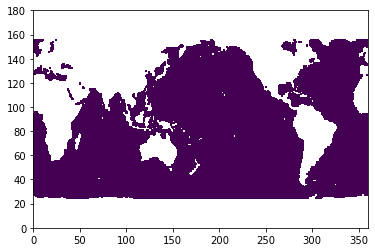

In [41]:
plt.pcolor(mask.reshape(180,360))

In [42]:
varis

['sum',
 'steric',
 'barystatic',
 'dynamic',
 'steric+dynamic',
 'steric+barystatic',
 'steric+barystatic+dynamic']

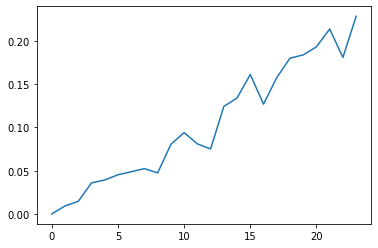

In [44]:
plt.plot(yt)

In [35]:

key = '1degree'
X = np.array(dic['sum']['trend']) + np.array(dic['alt']['trend'])
mask = np.array(X).flatten()
mask[np.isfinite(mask)] = 1
nn = len(mask[np.isfinite(mask)])

Y = np.array(dic['alt']['trend']).flatten()
Ye = np.array(dic['alt']['unc']).flatten()


nvar = len(varis)
n = len(mask)


r = []
R2 = []

for j,var in enumerate(varis):
    if len(var.split('+'))==1:
        X = np.array(dic[var]['trend']).flatten()
        Xe = np.array(dic[var]['unc']).flatten()
    else:
        X = np.array([dic[subvar]['trend'] for subvar in var.split('+')])
        X = np.sum(np.array(X),axis=0).flatten()
        Xe = np.array([dic[subvar]['trend'] for subvar in var.split('+')])
        Xe = np.sqrt(np.sum(np.array(Xe**2),axis=0)).flatten()

    for i, m in enumerate(mask):
        if np.isfinite(m):
            
            y = np.array(Y[i])
            ye = np.array(Ye[i])
            if np.isfinite(y):
                x = np.array(X[i])
                xe = np.array(Xe[i])
                if np.isfinite(x):
                    
                    rr=[]
                    RR = []
                    for i in range(N):
                        #xt = np.array(np.linspace(0,(x/t)*2,t)+create_noise(0,1,t)*np.linspace(0,(xe/t)*2,t))
                        xt = np.array(perturb_rate(x,xe,t))
                        yt = np.array(perturb_rate(y,ye,t))
                        xs[i] = np.cumsum(xt)[-1]
                        ys[i] = np.cumsum(yt)[-1]
                        _r,p = st.pearsonr(xt,yt)
                        rr.append(_r)
                        RR.append(metrics.r2_score(yt,xt))
                    ci = st.norm.interval(alpha=ci_level, loc=np.mean(rr), scale=np.array(rr).std())
                    r.append(ci[0]);r.append(ci[1]);r.append(np.nanmean(rr))
                    ci = st.norm.interval(alpha=ci_level, loc=np.mean(RR), scale=np.array(RR).std())
                    R2.append(ci[0]);R2.append(ci[1]);R2.append(np.nanmean(RR))

stats[key] = {'R2':R2,
           'r':r}
            


KeyboardInterrupt: 

In [ ]:
# plot
labels = ['1degree','dmap','som']
fig = plt.figure(figsize=(15,15))
ncol=len(labels)

i=1
varis = ['R2','r',
         # 'RMSE','nRMSE',
         # 'mRMSE'
        ]
nrow=len(varis)     
for label in labels:
    for var in varis:
        ax1 = plt.subplot(ncol,nrow,i)
        ax1.set_title('{} - {}'.format(label,var))
        ax1.boxplot(stats[label][var])
        # ax1.set_ylim(-2,2)
        i=i+1


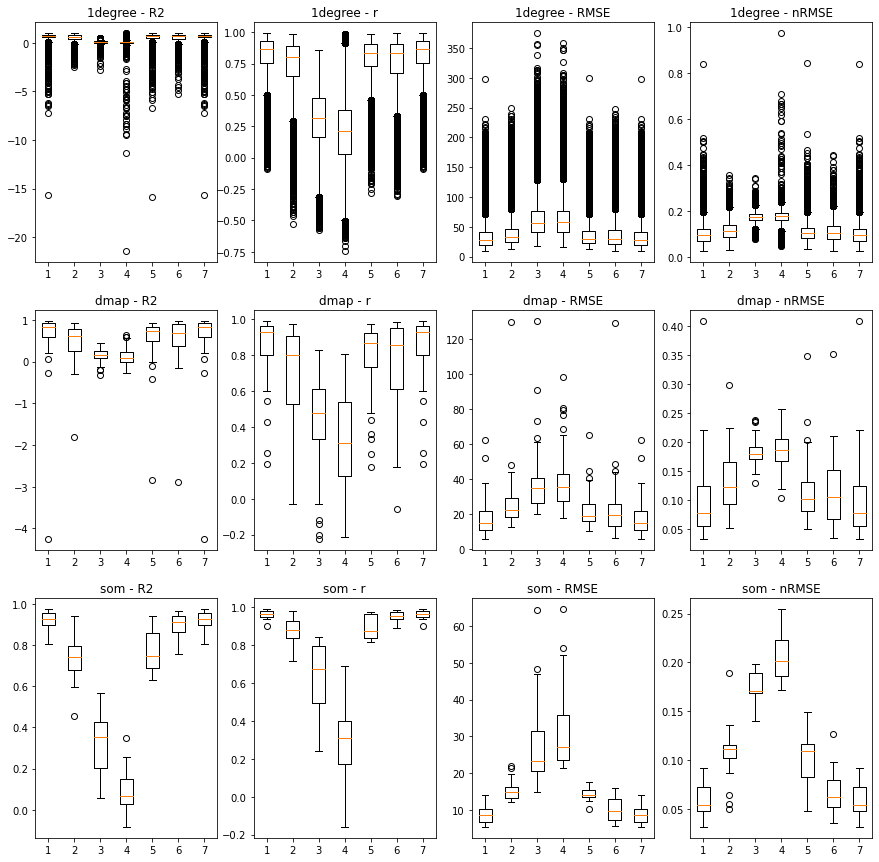

In [26]:
# plot
labels = ['1degree','dmap','som']
fig = plt.figure(figsize=(15,15))
ncol=len(labels)

i=1
varis = ['R2','r','RMSE','nRMSE',
         # 'mRMSE'
        ]
nrow=len(varis)     
for label in labels:
    for var in varis:
        ax1 = plt.subplot(ncol,nrow,i)
        ax1.set_title('{} - {}'.format(label,var))
        ax1.boxplot(stats[label][var])
        # ax1.set_ylim(-2,2)
        i=i+1


In [28]:
# make dataframe
combs = ['(alt,sum)','(alt,ste)','(alt,bar)','(alt,dyn)',
        '(alt,ste+dyn)','(alt,ste+bar)','(alt,ste+dyn+bar)' ]
varis = ['R2','r','RMSE','nRMSE',
         # 'mRMSE'
        ]
labels = ['1degree','dmap','som']
for ilabel, label in enumerate(labels):
    var = varis[0]
    
    data = np.array(stats[label][var])
    i,j = data.shape
    if ilabel==0:
        df = pd.DataFrame({'comb':np.tile(combs,i),
                           'budget':np.tile(label,i*j)
                          })
        for var in varis:
            df[var] = np.array(stats[label][var]).flatten()
    else:
        df2 = pd.DataFrame({'comb':np.tile(combs,i),
                   'budget':np.tile(label,i*j)
                  })
        for var in varis:
            df2[var] = np.array(stats[label][var]).flatten()
        df = df.append(df2)
        


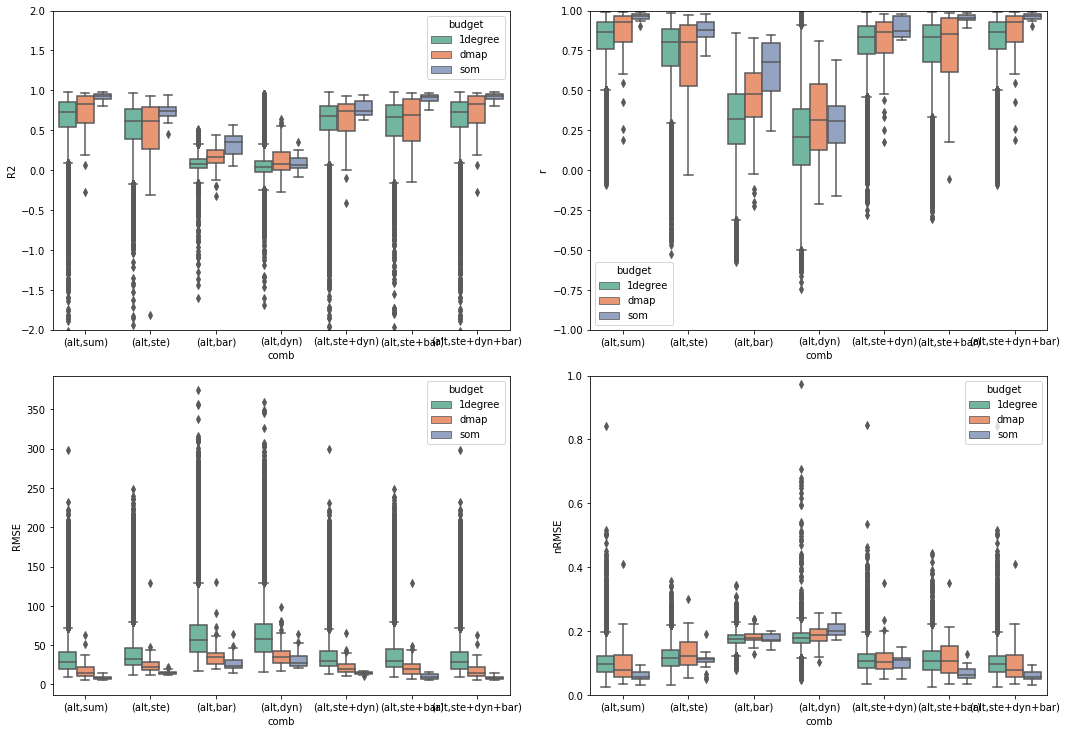

In [29]:
# plot grouped boxplot
ncol=len(varis)
nrow = 2
fig = plt.figure(figsize=(15,5*ncol))
for i,var in enumerate(varis):
    plt.subplot(ncol,nrow,i+1)
    sns.boxplot(x = df['comb'],
                y = df[var],
                hue = df['budget'],
                palette = 'Set2')
    if var=='R2':
        plt.ylim(-2,2)
    if var =='r':
        plt.ylim(-1,1)
    if var=='nRMSE':
        plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Save

In [32]:
df.to_pickle(path+"budget-stats.p")
df

# load pickle module
import pickle
# path = '/Volumes/LaCie_NIOZ/data/budget/'
# create a binary pickle file 
f = open(path+"budget-stats.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(dic,f)

# close file
f.close()

In [31]:
path

'/Volumes/LaCie_NIOZ/data/budget/'